In [5]:
from data_loading import load_data
from feature_engineering import apply_feature_engineering
import pandas as pd
import numpy as np

1. **Logistic Regression**
Pretty solid but not amazing—accuracy around 81%, and an F1 score of ~73% after tuning.
It’s fast and simple but struggles a bit with recall (69%), meaning it's missing some positive cases.

_______________________

2. **Random Forest**
Accuracy at 94.7%, and a strong F1 score of 92.5%.
Great balance between precision and recall, catching 86% of positive cases.
A really reliable option, especially after tuning.

___

3. **XGBoost**
The best performer Accuracy at 97.5%, with an  F1 score of 96.7%.
Near-perfect precision (99.8%) and a strong recall (93.7%).
Definitely the most powerful but might take longer to train.

___

4. **Naïve Bayes**
Meh. Accuracy at 80%, and an F1 score of ~70%, similar to Logistic Regression.
Works fast but not the best choice 
___
5. **Bernoulli Naïve Bayes**
 not good. Accuracy at 62.8%, and F1 at 19%—this one's not making the cut.



___

1. **Random Forest**

True Negatives (TN): 68,889 → Correctly classified negatives

False Positives (FP): 352 → Very few misclassified negatives

False Negatives (FN): 7,301 → Some missed positives

True Positives (TP): 35,434 → Strong positive classification




2. **Logistic Regression**

TN: 61,020

FP: 8,221 → Too many false positives

FN: 12,979 → High false negatives

TP: 29,756



3. **XGBoost (Best Performer)**

TN: 69,184

FP: 57 → Almost no false positives!

FN: 2,701 → Very few false negatives

TP: 40,034




4. **Gaussian Naïve Bayes**

TN: 63,475

FP: 5,766 → More false positives

FN: 16,501 → Too many missed positives

TP: 26,234



___


**Ensemble Model**

Overall Accuracy: 94.7% – solid and reliable.

Precision: 99.7% – almost no false positives.

Recall: 86.3% – catches most of the positive cases.

F1 Score: 92.6% – great balance between precision and recall.

Balanced Accuracy: 93.1% – good even with class imbalances.

ROC AUC: 98.8% – excellent at distinguishing between classes.

Additional metrics like Cohen’s Kappa (0.88) and MCC (0.89) show strong agreement between predictions and actual labels. Log Loss (0.2078) is low, meaning the model is well-calibrated.



In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
df = load_data()
df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7_LongDesc,ClmDiagnosisCode_7_ShortDesc,ClmDiagnosisCode_8_LongDesc,ClmDiagnosisCode_8_ShortDesc,ClmDiagnosisCode_9_LongDesc,ClmDiagnosisCode_9_ShortDesc,ClmDiagnosisCode_10_LongDesc,ClmDiagnosisCode_10_ShortDesc,Flag_Unknown_Procedures,Flag_Unknown_Diagnoses
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,Other and unspecified hyperlipidemia,Hyperlipidemia NEC/NOS,Secondary malignant neoplasm of other specifie...,Secondary malig neo NEC,"Acute kidney failure, unspecified",Acute kidney failure NOS,NaN,NaN,False,False
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,"Diabetes with neurological manifestations, typ...",DMII neuro uncntrld,"Hypertensive chronic kidney disease, unspecifi...",Hy kid NOS w cr kid I-IV,Unspecified essential hypertension,Hypertension NOS,NaN,NaN,False,False
4,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,"Diabetes with neurological manifestations, typ...",DMII neuro uncntrld,"Hypertensive chronic kidney disease, unspecifi...",Hy kid NOS w cr kid I-IV,Unspecified essential hypertension,Hypertension NOS,NaN,NaN,False,False


In [8]:
df = apply_feature_engineering(df)  

Starting feature engineering...
Adding datetime features...
Added datetime features. Time elapsed: 51.09s
Discretizing age...
Discretized age. Time elapsed: 51.10s
Filling in missing values...
Filled in missing values. Time elapsed: 54.65s
Transforming skewed distributions...
Transformed skewed distributions. Time elapsed: 54.67s
Encoding categorical columns...
Encoded categorical columns. Time elapsed: 60.52s
Dropping unnecessary columns...
Dropped unnecessary columns. Time elapsed: 60.82s
Feature engineering complete!


In [9]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559877 entries, 0 to 559876
Data columns (total 57 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Provider                         559877 non-null  int64  
 1   AttendingPhysician               559877 non-null  int64  
 2   OperatingPhysician               559877 non-null  int64  
 3   OtherPhysician                   559877 non-null  int64  
 4   ClmAdmitDiagnosisCode            559877 non-null  int64  
 5   TotalClaims                      559877 non-null  int64  
 6   Gender                           559877 non-null  int64  
 7   Race                             559877 non-null  int64  
 8   RenalDiseaseIndicator            559877 non-null  int64  
 9   State                            559877 non-null  int64  
 10  County                           559877 non-null  int64  
 11  NoOfMonths_PartACov              559877 non-null  int64  
 12  No

,Provider,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,TotalClaims,Gender,Race,RenalDiseaseIndicator,State,...,NumProcedures,HospitalStayDays,ClaimDuration,DaysBeforeAdmission,ClaimStartMonth,ClaimStartWeekday,ClaimStartYear,DaysSinceLastClaim,AgeAtClaim,AgeGroup
0,3928,53275,0,0,3022,60,1,1,0,39,...,6,6.0,6,0.0,4,6,2009,0.0,66,2
1,3923,4951,2133,0,2298,60,1,1,0,39,...,6,2.0,2,0.0,8,0,2009,141.0,66,2
2,4034,40843,0,5202,851,14,1,1,0,39,...,6,3.0,3,0.0,9,3,2009,17.0,66,2
3,1125,39020,23576,14718,1602,22,2,2,0,1,...,6,8.0,8,0.0,2,5,2009,0.0,95,3
4,1125,39020,23576,14718,1602,22,2,2,0,1,...,6,8.0,8,0.0,2,5,2009,0.0,95,3


In [41]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score ,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB,BernoulliNB

import matplotlib.pyplot as plt


In [36]:


def train_classification_models(data, target_column):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "nb_model": GaussianNB(),
        'Bernoulli': BernoulliNB(alpha=1.0, binarize=0.0),
        # "SVM": SVC(probability=True)  # Uncomment to include SVM
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        metrics = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None,
            "Cross-Validation F1 (Mean)": np.mean(cv_scores)
        }

        results[name] = {"model": model, "metrics": metrics}

        print(f"{name} Model Performance:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    return results


def train_optimized_classification_models(data, target_column, n_iter=10):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    param_distributions = {
        "Logistic Regression": {
            "model": LogisticRegression(),
            "params": {"C": np.logspace(-3, 3, 10), "penalty": ["l1", "l2"], "solver": ["liblinear"]}
        },
        "Random Forest": {
            "model": RandomForestClassifier(random_state=42),
            "params": {"n_estimators": np.arange(50, 300, 50), "max_depth": [5, 10, None], "min_samples_split": [2, 5, 10]}
        },
        "XGBoost": {
            "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "params": {"n_estimators": np.arange(50, 300, 50), "learning_rate": np.linspace(0.01, 0.2, 5), "max_depth": [3, 5, 10]}
        },
        "Gaussian Naïve Bayes": {
            "model": GaussianNB(),
            "params": {"var_smoothing": np.logspace(-9, -6, 10)}
        },
        # "SVM": {
        #     "model": SVC(probability=True),
        #     "params": {"C": np.logspace(-3, 3, 10), "kernel": ["linear", "rbf", "poly"]}
        # }
    }

    best_models = {}
    for name, config in param_distributions.items():
        print(f"\nTraining and tuning {name}...")

        if name == "Gaussian Naïve Bayes":
            model = config["model"]
            model.fit(X_train, y_train)
            best_model = model
            best_params = None  
        else:
            random_search = RandomizedSearchCV(
                config["model"], config["params"], n_iter=n_iter, cv=5, scoring="f1", n_jobs=-1, random_state=42
            )
            random_search.fit(X_train, y_train)
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_

        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')

        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
        metrics = {
            "Best Params": best_params,
            "Cross-Validation F1 (Mean)": np.mean(cv_scores),
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
        }

        best_models[name] = {"model": best_model, "metrics": metrics}

        print(f"\n{name} Best Parameters: {best_params}")
        for metric, value in metrics.items():
            if metric != "Best Params":
                print(f"{metric}: {value:.4f}")

    return best_models

### confusion matric
def analyze_model_errors(model, X_test, y_test):
    """
    Analyze errors using a confusion matrix.
    """
    X = df.drop(columns=['PotentialFraud'])
    y = df['PotentialFraud']

    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
    disp.plot(cmap="Blues")
    
    print("\nConfusion Matrix:")
    print(cm)
from sklearn.ensemble import VotingClassifier


### train ensemble
def train_voting_ensemble(best_models, X_train, y_train):
    X = df.drop(columns=['PotentialFraud'])
    y = df['PotentialFraud']

    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    voting_clf = VotingClassifier(
        estimators=[
            ("Random Forest", best_models["Random Forest"]["model"]),
            #("Logistic Regression", best_models["Logistic Regression"]["model"]),
            ("XGBoost", best_models["XGBoost"]["model"])
        ],
        voting="soft"  # Soft voting considers probability predictions
    )

    voting_clf.fit(X_train, y_train)
    return voting_clf
from sklearn.metrics import (
    balanced_accuracy_score,
    cohen_kappa_score,
    matthews_corrcoef,
    log_loss,
    roc_auc_score,
    classification_report
)


###ensemble model metrics
def evaluate_final_model(model, X_train, y_train, X_test, y_test, cv=5):
  
    
  
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    
    cv_f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    cross_val_f1_mean = np.mean(cv_f1_scores)

   
    metrics = {
        "Cross-Validation F1 (Mean)": cross_val_f1_mean,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
        "Cohen's Kappa": cohen_kappa_score(y_test, y_pred),
        "Matthews Corr Coeff (MCC)": matthews_corrcoef(y_test, y_pred),
        "Log Loss": log_loss(y_test, y_prob) if y_prob is not None else None,
        "ROC AUC Score": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

    print("\nFinal Model Performance on Test Set:")
    print(classification_report(y_test, y_pred))

    for metric, value in metrics.items():
        if value is not None:
            print(f"{metric}: {value:.4f}")

    return metrics


In [12]:
results = train_classification_models(df, 'PotentialFraud')



Training Logistic Regression...
Logistic Regression Model Performance:
Accuracy: 0.7999
Precision: 0.8095
Recall: 0.6222
F1 Score: 0.7036
ROC AUC: 0.8397
Cross-Validation F1 (Mean): 0.7000

Training Random Forest...
Random Forest Model Performance:
Accuracy: 0.9337
Precision: 0.9895
Recall: 0.8351
F1 Score: 0.9058
ROC AUC: 0.9845
Cross-Validation F1 (Mean): 0.8963

Training XGBoost...
XGBoost Model Performance:
Accuracy: 0.9706
Precision: 0.9927
Recall: 0.9299
F1 Score: 0.9602
ROC AUC: 0.9955
Cross-Validation F1 (Mean): 0.9605

Training nb_model...
nb_model Model Performance:
Accuracy: 0.8011
Precision: 0.8198
Recall: 0.6139
F1 Score: 0.7021
ROC AUC: 0.8043
Cross-Validation F1 (Mean): 0.6996

Training Bernoulli...
Bernoulli Model Performance:
Accuracy: 0.6283
Precision: 0.5648
Recall: 0.1130
F1 Score: 0.1883
ROC AUC: 0.5317
Cross-Validation F1 (Mean): 0.1909


In [16]:
best_models = train_optimized_classification_models(df, 'PotentialFraud')


Training and tuning Logistic Regression...

Logistic Regression Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1000.0}
Cross-Validation F1 (Mean): 0.7362
Accuracy: 0.8107
Precision: 0.7835
Recall: 0.6963
F1 Score: 0.7373
ROC AUC: 0.8630

Training and tuning Random Forest...

Random Forest Best Parameters: {'n_estimators': 250, 'min_samples_split': 5, 'max_depth': None}
Cross-Validation F1 (Mean): 0.8969
Accuracy: 0.9317
Precision: 0.9902
Recall: 0.8292
F1 Score: 0.9025
ROC AUC: 0.9842

Training and tuning XGBoost...


/Users/moulang/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:29:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/moulang/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:29:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/moulang/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:29:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/moulang/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:29:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Best Parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.0575}
Cross-Validation F1 (Mean): 0.9664
Accuracy: 0.9754
Precision: 0.9986
Recall: 0.9368
F1 Score: 0.9667
ROC AUC: 0.9982

Training and tuning Gaussian Naïve Bayes...

Gaussian Naïve Bayes Best Parameters: None
Cross-Validation F1 (Mean): 0.6996
Accuracy: 0.8011
Precision: 0.8198
Recall: 0.6139
F1 Score: 0.7021
ROC AUC: 0.8043


Random Forest


Confusion Matrix:
[[68889   352]
 [ 7301 35434]]


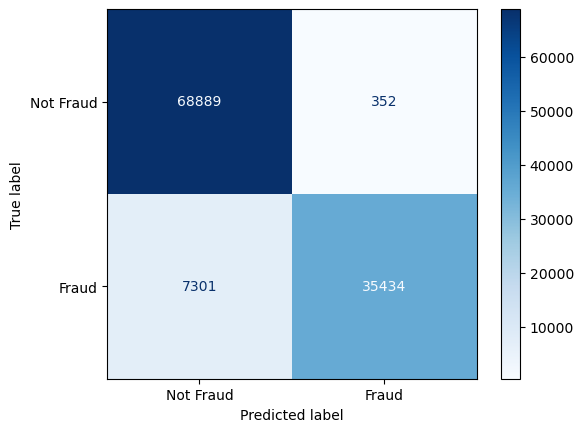

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("Random Forest\n")
analyze_model_errors(best_models["Random Forest"]["model"], X_test, y_test)


Logistic Regression


Confusion Matrix:
[[61020  8221]
 [12979 29756]]


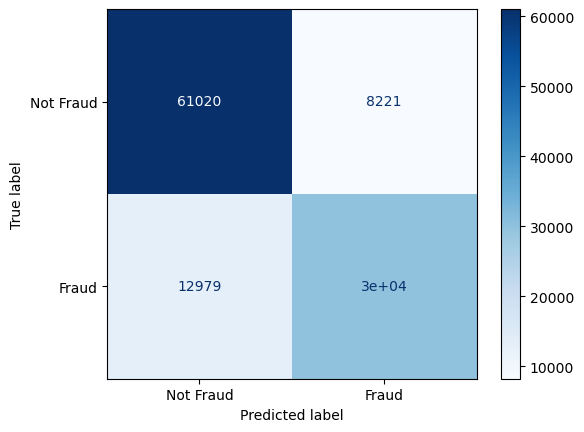

In [24]:
print("Logistic Regression\n")

analyze_model_errors(best_models["Logistic Regression"]["model"], X_test, y_test)

XGBoost 


Confusion Matrix:
[[69184    57]
 [ 2701 40034]]


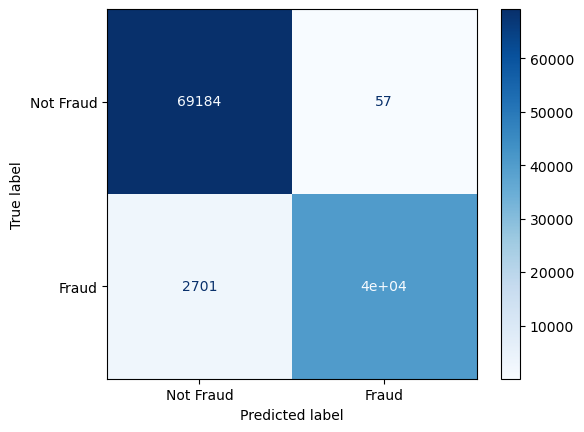

In [25]:
print("XGBoost \n")

analyze_model_errors(best_models["XGBoost"]["model"], X_test, y_test)

Gaussian Naïve Bayes


Confusion Matrix:
[[63475  5766]
 [16501 26234]]


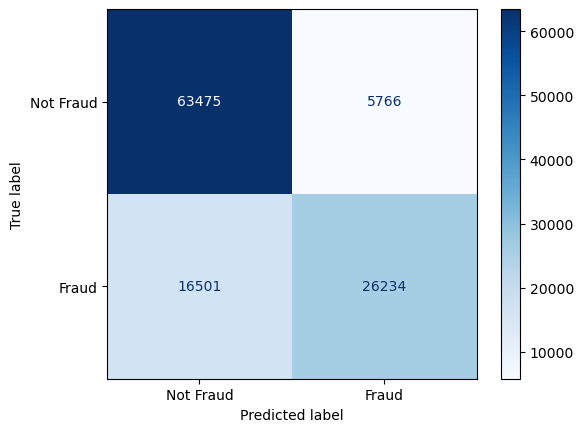

In [32]:
print("Gaussian Naïve Bayes\n")
analyze_model_errors(best_models["Gaussian Naïve Bayes"]["model"], X_test, y_test)

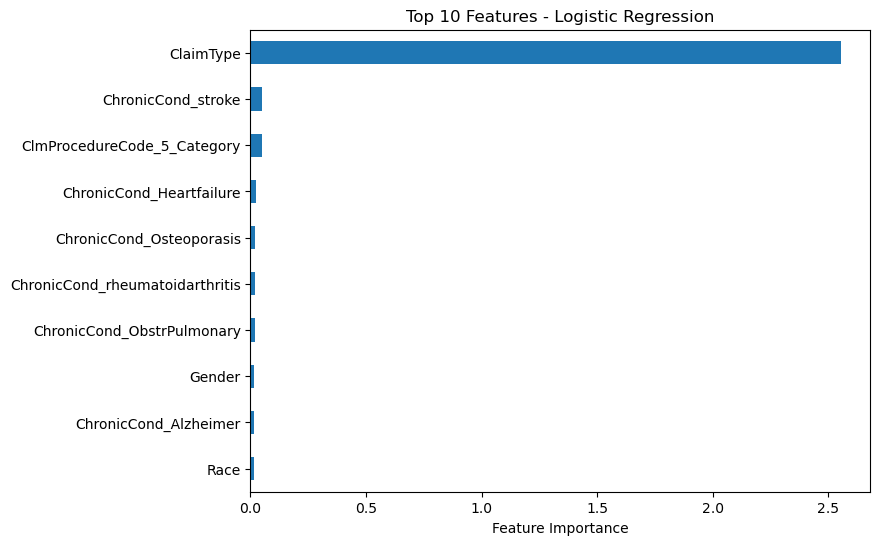

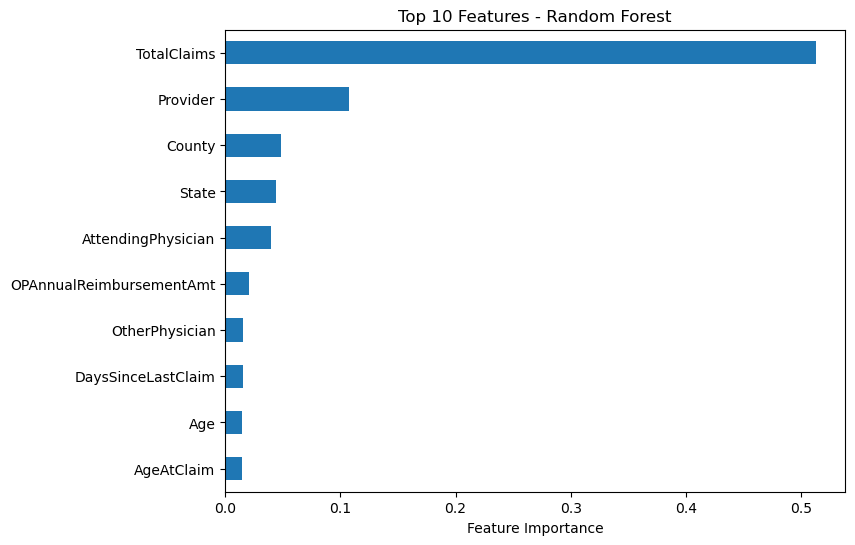

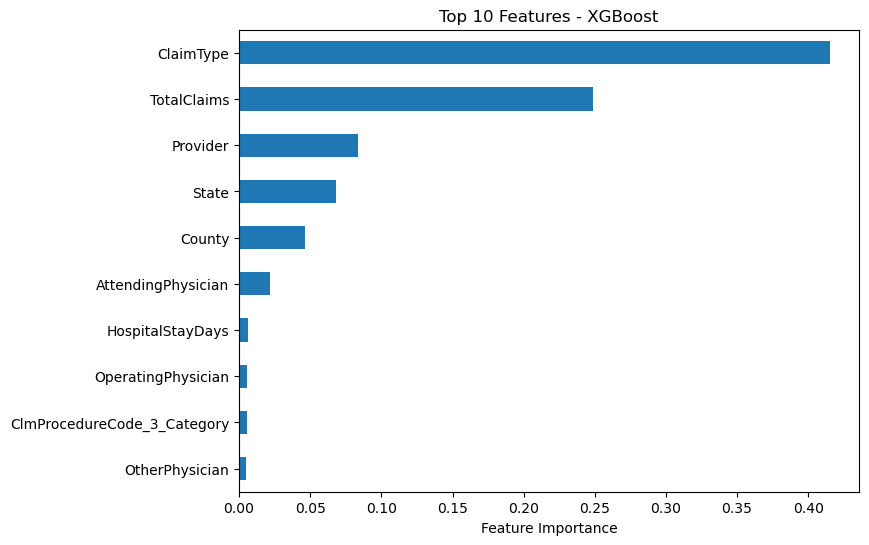

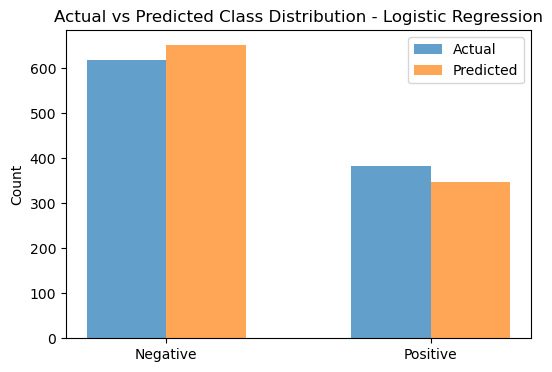

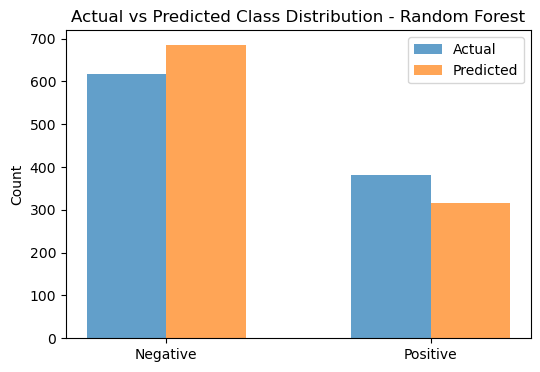

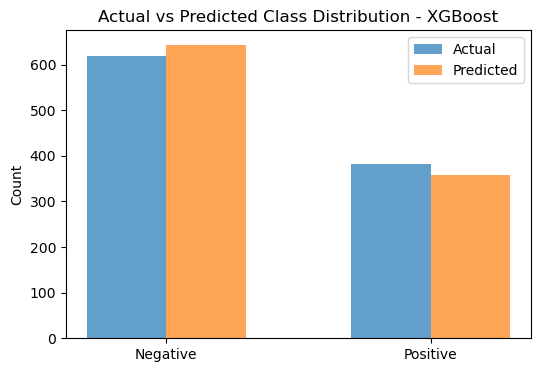

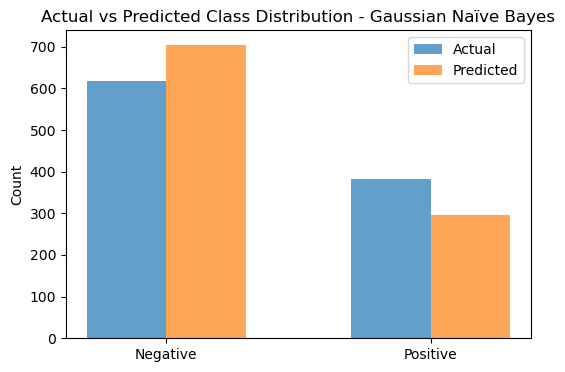

In [45]:
subset_size = 1000
X_test_subset = X_test[:subset_size]
y_test_subset = y_test[:subset_size]

model_predictions = {}
for model_name, model_info in best_models.items():
    model = model_info["model"]
    y_pred_subset = model.predict(X_test_subset)
    model_predictions[model_name] = y_pred_subset

feature_importances = {}
for model_name, model_info in best_models.items():
    model = model_info["model"]
    
    if hasattr(model, "feature_importances_"):  
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):  
        importance = np.abs(model.coef_[0])
    else:
        continue  

    feature_importances[model_name] = pd.Series(importance, index=X_test.columns).sort_values(ascending=False)
for model_name, importance_series in feature_importances.items():
    plt.figure(figsize=(8, 6))
    importance_series[:10].plot(kind="barh", title=f"Top 10 Features - {model_name}")
    plt.xlabel("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()
for model_name, y_pred_subset in model_predictions.items():
    plt.figure(figsize=(6, 4))
    actual_counts = pd.Series(y_test_subset).value_counts().sort_index()
    predicted_counts = pd.Series(y_pred_subset).value_counts().sort_index()

    width = 0.3  
    x = np.arange(len(actual_counts))  

    plt.bar(x - width/2, actual_counts, width=width, label="Actual", alpha=0.7)
    plt.bar(x + width/2, predicted_counts, width=width, label="Predicted", alpha=0.7)

    plt.xticks(ticks=x, labels=["Negative", "Positive"])
    plt.ylabel("Count")
    plt.title(f"Actual vs Predicted Class Distribution - {model_name}")
    plt.legend()
    plt.show()


In [37]:
from sklearn.ensemble import VotingClassifier

voting_model = train_voting_ensemble(best_models, X_train, y_train)


In [38]:

final_metrics = evaluate_final_model(voting_model, X_train, y_train, X_test, y_test)



Final Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     69241
           1       1.00      0.91      0.95     42735

    accuracy                           0.97    111976
   macro avg       0.97      0.96      0.96    111976
weighted avg       0.97      0.97      0.97    111976

Cross-Validation F1 (Mean): 0.9508
Accuracy: 0.9655
Precision: 0.9986
Recall: 0.9108
F1 Score: 0.9527
Balanced Accuracy: 0.9550
Cohen's Kappa: 0.9256
Matthews Corr Coeff (MCC): 0.9280
Log Loss: 0.1396
ROC AUC Score: 0.9966
